In [12]:
import re
from mongoengine import connect, disconnect
from pycoshark.mongomodels import Project, VCSSystem, Commit, FileAction, Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message,PullRequestSystem
from pycoshark.utils import create_mongodb_uri_string


# You may have to update this dict to match your DB credentials
disconnect()
credentials = {'db_user': '',
               'db_password': '',
               'db_hostname': 'localhost',
               'db_port': 27017,
               'db_authentication_database': '',
               'db_ssl_enabled': False}

uri = create_mongodb_uri_string(**credentials)

connect('smartshark_2_1', host=uri, alias='default')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [13]:
commit_id = []
project = Project.objects(name='opennlp').get()

for fa in FileAction.objects.all():
    if fa.induces != [] :
        for i in fa.induces:
            if i['szz_type'] == 'inducing':
                commit = Commit.objects(id=fa.commit_id).get()
                vcs_system = VCSSystem.objects(id=commit.vcs_system_id, project_id=project.id)
                if vcs_system and commit.id not in commit_id:
                    commit_id.append(commit.id)
                    print(commit.id)

5b27c649eee553716577d036
5b27c64aeee553715e77d094
5b27c64aeee553715f77d045
5b27c649eee553716177d04c
5b27c64aeee553716577d054
5b27c64aeee553716c77d052
5b27c64beee553715e77d0c1
5b27c64beee553715e77d0cb
5b27c64beee553715e77d0e3
5b27c64beee553716477d0e0
5b27c64beee553716577d101
5b27c64beee553716777d0bc
5b27c64beee553716977d0e6
5b27c64ceee553716077d0d9
5b27c64beee553716177d0d0
5b27c64ceee553716177d0dc
5b27c64ceee553716177d0ff
5b27c64beee553716377d0bc
5b27c64ceee553716477d1aa
5b27c64ceee553716777d11a
5b27c64ceee553716877d0e0
5b27c64deee553716477d1cb
5b27c64deee553716577d188
5b27c64deee553716777d156
5b27c64deee553716a77d103
5b27c64eeee553716477d20f
5b27c64eeee553716677d15c
5b27c64eeee553716a77d13c
5b27c64eeee553715d77d278
5b27c64feee553715e77d223
5b27c64eeee553716977d1a6
5b27c64feee553716a77d16c
5b27c650eee553715d77d334
5b27c650eee553715e77d238
5b27c650eee553716177d20f
5b27c650eee553716377d1fd
5b27c650eee553716677d1ff
5b27c650eee553716a77d1fc
5b27c651eee553715d77d347
5b27c651eee553715e77d268


KeyboardInterrupt: 

In [17]:
from pycoshark.mongomodels import PullRequest, PullRequestCommit

my_dict = []

print("Number of total bug inducing commits in tika: " + str(len(commit_id)))
pull_request_system = PullRequestSystem.objects(project_id=project.id).get()
pr = PullRequest.objects(pull_request_system_id=pull_request_system.id)
print("Number of pull-request in the project: " + str(pr.count()))

for item in pr:
    pr_commit = PullRequestCommit.objects(pull_request_id=item.id)
    for value in pr_commit:
        if value.commit_id in commit_id:
            
            for key in my_dict:
                if key["pull_request"] == item.id:
                    key["commit_count"] += 1
            else:
                dict = {"pull_request":item.id,
                       "commit_count": 1,
                       "time_difference": item.merged_at - item.created_at}
                my_dict.append(dict)
                                             

print(len(my_dict))

Number of total bug inducing commits in tika: 339
Number of pull-request in the project: 389
16


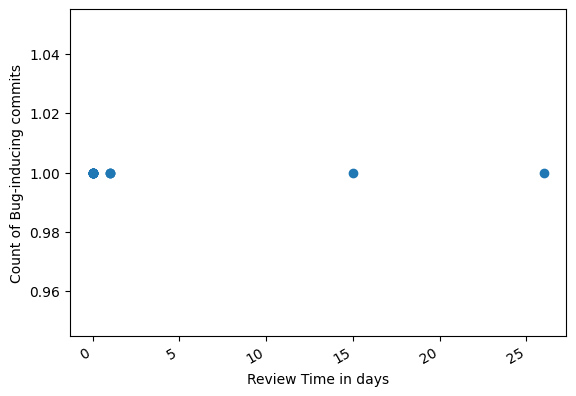

In [18]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np

x = []
y = []
for item in my_dict:
    x.append(item["time_difference"].days)
    y.append(item["commit_count"])

plt.scatter(x,y)    
plt.gcf().autofmt_xdate()
plt.xlabel("Review Time in days")
plt.ylabel("Count of Bug-inducing commits")
plt.show()

In [16]:
vcs_system = VCSSystem.objects(project_id=project.id).get()


print('VCS System:', vcs_system.url)

# We can now fetch the commits and analyze them
num_commits = Commit.objects(vcs_system_id=vcs_system.id).count()

print('Number of commits:', num_commits)

count_bugfix = 0
count_linked_issue = 0
count_hunks = 0
count_refactorings_refdiff = 0
count_refactorings_refactoringminer = 0

# Only limits the fields we are reading to the required fields. This is important for the performance.
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('labels', 'linked_issue_ids'):
    if commit.labels is not None and 'validated_bugfix' in commit.labels and commit.labels['validated_bugfix']==True:
        count_bugfix += 1
    if commit.linked_issue_ids is not None and len(commit.linked_issue_ids)>0:
        count_linked_issue += 1
        
    # File actions group all changed hunks in a commit of the same file
    for fa in FileAction.objects(commit_id=commit.id):
        count_hunks += Hunk.objects(file_action_id=fa.id).count()
        
    count_refactorings_refdiff += Refactoring.objects(commit_id=commit.id, detection_tool='"refDiff"').count()
    count_refactorings_refactoringminer += Refactoring.objects(commit_id=commit.id, detection_tool='rMiner').count()

        
print('Number of bug fixing commits:', count_bugfix)
print('Number of commits that link to a Jira issue:', count_linked_issue)
print('Number of hunks for all commits:', count_hunks)
print('Number of refactorings detected by refDiff:', count_refactorings_refdiff)
print('Number of refactorings detected by RefactoringMiner:', count_refactorings_refactoringminer)

VCS System: https://github.com/apache/opennlp.git
Number of commits: 2685
Number of bug fixing commits: 144
Number of commits that link to a Jira issue: 1722
Number of hunks for all commits: 41542
Number of refactorings detected by refDiff: 0
Number of refactorings detected by RefactoringMiner: 1675
